# Periodic Stimulation

## Setup

Importage

In [1]:
# Generic stuff
import os,sys,glob, numpy as np, pandas as pd
from scipy.io import loadmat
from itertools import product
from scipy.interpolate import interp1d
from copy import deepcopy
import nibabel as nib

# Viz stuff
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns


# CTWC model code
sys.path.append('../ctwc')
from ctwc_model import (run_net_sim,decimate_surface,plot_surface_mpl,plot_surface_mpl_mv,
                           make_brain_movie,sim_summary,FreqVsAmpPsweep)

/nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Define some variables

In [2]:
# 1-node weights & delays
weights_1N = np.array([[1.]])
delays_1N = np.array([[1.]])

In [3]:
cv = 4.

# this rearanges the l2k8 indices to match the sorted aparc labels used in the meg analysis

l2k8_to_aparc_sort_idx = np.array([22, 21, 20, 23, 18, 17, 19, 14, 24, 30, 16, 28, 10, 25, 15, 13, 29,
       32, 31,  9, 26, 33, 27,  8,  5, 12,  7,  4,  3, 11,  0,  1,  6,  2,
       64, 62, 63, 65, 60, 59, 61, 56, 66, 72, 58, 70, 67, 71, 52, 57, 55,
       74, 73, 51, 68, 75, 69, 50, 47, 54, 49, 46, 53, 42, 43, 45, 48, 44])

orig_to_abey_idx = np.array([46, 32, 50, 58, 16,  6, 22, 42, 26, 20, 12, 34, 16,  8, 64, 18, 60,
       66, 30,  0, 62, 44, 48,  4, 56,  2, 54, 36, 40, 38, 24, 28, 52, 10,
       47, 33, 51, 59, 15,  7, 23, 43, 27, 21, 13, 35, 17,  9, 65, 19, 61,
       67, 31,  1, 63, 45, 49,  5, 57,  3, 55, 37, 41, 39, 25, 29, 53, 11])

l2k8_to_abey_idx = np.array([13, 10, 19, 17, 28, 20, 22, 21, 23, 14, 24, 25, 28, 26, 27, 33, 31,
       32, 29, 30, 16, 15,  9,  8,  7, 12,  6,  5,  4,  1,  0,  3, 11,  2,
       55, 52, 61, 59, 60, 62, 64, 63, 65, 56, 66, 67, 70, 68, 69, 75, 73,
       74, 71, 72, 58, 57, 51, 50, 49, 54, 48, 47, 46, 43, 42, 45, 53, 44])

l2k8_in_orig = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75])


sfreq = 1000.    
freq_bands = {'delta': (2, 4),
              'theta': (5, 7),
              'alpha': (8, 12),
              'beta': (15, 29),
              'gamma': (30, 45)}

freqs = freq_bands.keys()

Load SC data

In [4]:
l2k8_w = np.loadtxt('../data/hcp_grpavg_l2k8_sc33_weights.npy')

l2k8_tl = np.loadtxt('../data/hcp_grpavg_l2k8_sc33_tractlengths.npy')

df_l2k8_w = pd.DataFrame(l2k8_w)

df_l2k8_tl = pd.DataFrame(l2k8_tl)

df_l2k8_w *= ((np.eye(83)*-1) + 1)
df_l2k8_wlog = np.log1p(df_l2k8_w)

df_l2k8_wlog_divmax = df_l2k8_wlog.copy()
df_l2k8_wlog_divmax/= df_l2k8_wlog.max()


df_l2k8_del = df_l2k8_tl / cv

_df_d = df_l2k8_del.copy()
_df_d[df_l2k8_wlog_divmax<0.2] = 0.

_df_w = df_l2k8_wlog_divmax.copy()
_df_w[_df_w<0.2] = 0

In [5]:
l2k8_lV1_idx = 21 # pericalcarine
l2k8_lM1_idx = 24 # precentral
l2k8_lA1_idx = 30 # superiortemporal
l2k8_lS1_idx = 22 # postcentral
l2k8_lDLPFC_idx = 12 # lateralorbitofrontal
l2k8_lVLPFC_idx = 19 # parsorbitalis

focal_nodes = [l2k8_lV1_idx,l2k8_lA1_idx,l2k8_lM1_idx,l2k8_lS1_idx,
               l2k8_lDLPFC_idx,l2k8_lVLPFC_idx]
focal_node_names = ['lV1','lA1','lM1','lS1','lDLPFC','lVLPFC']


# low resolution = sparser set ('short')
freqs_s = np.arange(0.01,100.,10./3.)
amps_s = np.arange(0,3,0.1) 

# high resolution = denser set ('long')
freqs_l = np.arange(0,100,1)
amps_l = np.arange(0.,2.05,0.05)

# 1-node weights & delays
weights_1N = np.array([[1.]])
delays_1N = np.array([[1.]])

weights_l2k8 = _df_w.values
delays_l2k8  = _df_d.values
n_nodes_l2k8 = weights_l2k8.shape[0]

In [6]:
lhi_file = '../data/fsav5_lh.inflated'
rhi_file = '../data/fsav5_rh.inflated'

lhp_file = '../data/fsav5_lh.pial'
rhp_file = '../data/fsav5_rh.pial'

lh_annot_file = '../data/fsav5_lh.aparc.annot'
rh_annot_file = '../data/fsav5_rh.aparc.annot'

lhi_vtx,lhi_tri = nib.freesurfer.read_geometry(lhi_file)
rhi_vtx,rhi_tri = nib.freesurfer.read_geometry(rhi_file)

lhp_vtx,lhp_tri = nib.freesurfer.read_geometry(lhp_file)
rhp_vtx,rhp_tri = nib.freesurfer.read_geometry(rhp_file)

lh_annot = nib.freesurfer.read_annot(lh_annot_file)
rh_annot = nib.freesurfer.read_annot(rh_annot_file)

vtx_l2k8_lh = lhp_vtx
tri_l2k8_lh = lhp_tri
rm_l2k8_lh = lh_annot[0]


vtx_l2k8_rh = rhp_vtx
tri_l2k8_rh = rhp_tri
rm_l2k8_rh = rh_annot[0]

vtx_l2k8_lhrh = np.concatenate([vtx_l2k8_lh,vtx_l2k8_rh], axis=0)
tri_l2k8_lhrh = np.concatenate([tri_l2k8_lh,tri_l2k8_rh+10242],axis=0)

rm_l2k8_rh_p1 = rm_l2k8_rh + 36
rm_l2k8_rh_p1[rm_l2k8_rh == 0] = 0

rm_l2k8_lhrh = np.concatenate([rm_l2k8_lh, rm_l2k8_rh_p1], axis=0)
rm_l2k8_lhrh

hemi = np.ones_like(rm_l2k8_lhrh)
hemi[:10242] = 0
hemi

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

Define some functions

In [7]:
def get_psweep_dfs(ps_res,mul_cols=1.,mul_rows=1.):
    
    # Mean activity
    df = ps_res['all_dat']['e'][0].unstack('t').mean(axis=1).unstack('stim_freq').iloc[::-1,:].copy()
    df.columns = df.columns * mul_cols
    df.index = df.index * mul_rows
    df.columns = ['%1.2f' %f for f in df.columns]
    df.index = ['%1.2f' %f for f in df.index]
    df_mn = df
    
    # Periodogram maximum frequency
    df =  ps_res['all_per_maxfreqs']['e'].unstack('stim_freq').iloc[::-1,:].copy()
    df.columns = df.columns * mul_cols
    df.index = df.index * mul_rows
    df.columns = ['%1.2f' %f for f in df.columns]
    df.index = ['%1.2f' %f for f in df.index]
    df_pmf = df

    # Periodogram maximum amplitude
    df = ps_res['all_per_maxamps']['e'].unstack('stim_freq').iloc[::-1,:].copy()
    df.columns = df.columns * mul_cols
    df.index = df.index * mul_rows
    df.columns = ['%1.2f' %f for f in df.columns]
    df.index = ['%1.2f' %f for f in df.index]
    df_pma =  df

    # Welch maximum frequency
    df = ps_res['all_wel_maxfreqs']['e'].unstack('stim_freq').iloc[::-1,:].copy()
    df.columns = df.columns * mul_cols
    df.index = df.index * mul_rows
    df.columns = ['%1.2f' %f for f in df.columns]
    df.index = ['%1.2f' %f for f in df.index]
    df_wmf = df

    # Welch maximum amplitude
    df = ps_res['all_wel_maxamps']['e'].unstack('stim_freq').iloc[::-1,:].copy()
    df.columns = df.columns * mul_cols
    df.index = df.index * mul_rows
    df.columns = ['%1.2f' %f for f in df.columns]
    df.index = ['%1.2f' %f for f in df.index]
    df_wma = df

    return df_mn,df_pmf,df_pma,df_wmf,df_wma

## Do it

In [8]:
ssX_params = dict(I_o=0.,
             wee = 1.4,wei = 1.4,
                  wie = -2.,wii = -0.5,wertn = 0.6,weth = .6,
            wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,D_e = .0001,D_i= .0001,
            D_th = 0.0001,D_rtn = 0.0001,T = 1024,P=1,Q = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,g = -0.9,a_e = 0.3,
            a_i = 0.5,a_th = 0.2,a_rtn = 0.2,i_e = -0.35,i_i = -0.3,i_th = 0.5,
            i_rtn = -0.8,tau1  = 20.,tau2 = 5.,T_transient=1000,
            stim_freq=35.,stim_amp=0.5,
             weights=weights_1N,delays=delays_1N,K=1,
             return_ts=True,compute_connectivity=False,#True,
             stim_type='sinewave',stim_pops=['e'])

In [9]:
ssX_r_params = deepcopy(ssX_params)
ssX_r_params['I_o'] = 0.

ssX_t_params = deepcopy(ssX_params)
ssX_t_params['I_o'] = 1.5

In [10]:
%%time

ssX_lfr_r_res = FreqVsAmpPsweep(ssX_r_params,freqs_s,amps_s,n_jobs=8,concat_res=True,return_ts=True) 
ssX_lfr_r_dfs = get_psweep_dfs(ssX_lfr_r_res)

ssX_lfr_t_res = FreqVsAmpPsweep(ssX_t_params,freqs_s,amps_s,n_jobs=8,concat_res=True,return_ts=True) 
ssX_lfr_t_dfs = get_psweep_dfs(ssX_lfr_t_res)

started: 2019-06-11 12:19:03.966138
finished: 2019-06-11 12:21:21.099362
duration: 0:02:17.133224
started: 2019-06-11 12:21:21.474952
finished: 2019-06-11 12:22:47.886372
duration: 0:01:26.411420
CPU times: user 14.7 s, sys: 952 ms, total: 15.6 s
Wall time: 3min 44s


In [11]:
%%time
ssX_hfr_r_res = FreqVsAmpPsweep(ssX_r_params,freqs_l,amps_l,n_jobs=8,concat_res=True,return_ts=True) 
ssX_hfr_r_dfs = get_psweep_dfs(ssX_hfr_r_res)

ssX_hfr_t_res = FreqVsAmpPsweep(ssX_t_params,freqs_l,amps_l,n_jobs=8,concat_res=True,return_ts=True) 
ssX_hfr_t_dfs = get_psweep_dfs(ssX_hfr_t_res)

started: 2019-06-11 12:22:48.387818
finished: 2019-06-11 12:29:28.718363
duration: 0:06:40.330545
started: 2019-06-11 12:29:30.285559
finished: 2019-06-11 12:36:16.591147
duration: 0:06:46.305588
CPU times: user 1min 2s, sys: 5.18 s, total: 1min 8s
Wall time: 13min 29s


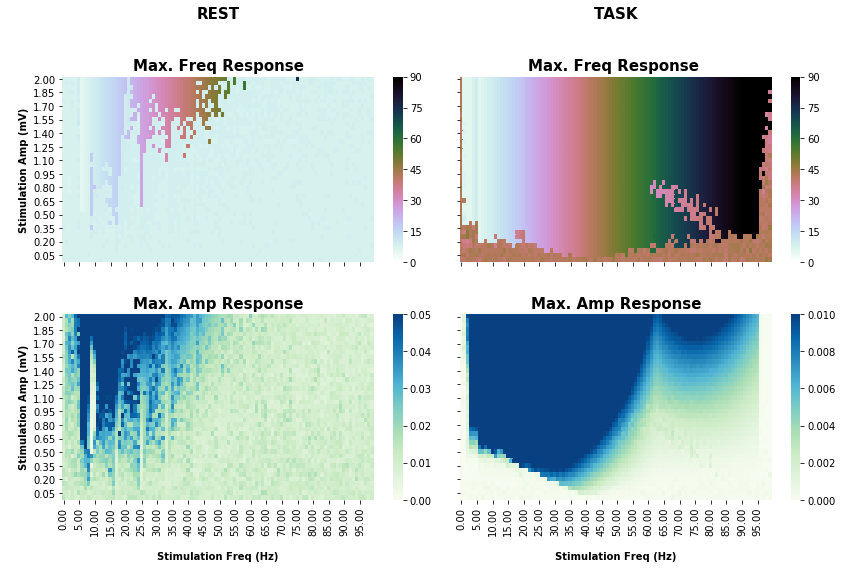

In [12]:
df_mn_r,df_pmf_r,df_pma_r,df_wmf_r,df_wma_r =  ssX_hfr_r_dfs # ps2_dfs_2['1N_r_spiketrain_hfr']
df_mn_t,df_pmf_t,df_pma_t,df_wmf_t,df_wma_t = ssX_hfr_t_dfs

fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(12,8))


"""
1. Maximum frequency responses
"""
a = ax[0][0]
sns.heatmap(df_pmf_r,ax=a,cmap=cm.cubehelix_r,vmin=0,vmax=90)#,vmin=0.,vmax=100.)#,vmax=100.)
a.set_title('REST\n\n\nMax. Freq Response', fontweight='bold', fontsize=15)
a.set_ylabel('\nStimulation Amp (mV)',fontweight='bold')
a.set_xticklabels('')
 
a= ax[0][1]
sns.heatmap(df_pmf_t,ax=a,cmap=cm.cubehelix_r,vmin=0,vmax=90)#,vmin=0.,vmax=100.)#,vmax=100.)
a.set_title('TASK\n\n\nMax. Freq Response ', fontweight='bold', fontsize=15)
a.set_xticklabels('')
a.set_yticklabels('')



"""
2. Maximum amplitude responses
"""

a= ax[1][0]
sns.heatmap(df_pma_r,ax=a,cmap=cm.GnBu,vmin=0,vmax=0.05)#cividis)#,vmin=0.,vmax=0.02)#$,vmax=0.1)
a.set_title('\nMax. Amp Response', fontweight='bold', fontsize=15)
a.set_xlabel('\nStimulation Freq (Hz)', fontweight='bold')
a.set_ylabel('\nStimulation Amp (mV)',fontweight='bold')

a= ax[1][1]
sns.heatmap(df_pma_t,ax=a,cmap=cm.GnBu,vmin=0,vmax=0.01)#gist_rainbow)#,vmin=0.,vmax=0.02)#,vmax=0.02)#,vmax=0.1)
a.set_title('\nMax. Amp Response', fontweight='bold', fontsize=15)
a.set_xlabel('\nStimulation Freq (Hz)', fontweight='bold')
a.set_yticklabels('')


plt.tight_layout()


#plt.savefig('FigX.png', bbox_inches='tight', transparent=True,dpi=600)
#plt.close()


#Image('FigX.png')

In [13]:
# TUESDAY - IF THE FIG ABOVE IS PRODUCED, GOOD. 

# THEN NEED TO RE-DO WITH NEW PARAMS...